---
#Imports

In [ ]:
!pip install Pillow
!pip install ultralytics

In [ ]:
import os
import shutil
import random
import zipfile
import pandas as pd
import yaml

from ultralytics import YOLO
from google.colab import drive
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

---
#Function Definitions

In [ ]:
def split_files(folder):
  """Splits files in a folder into training, testing, and validation sets within the same folder.

  Args:
    folder: Path to the folder containing the files to be split.
  """
  # Get a list of all files in the folder
  files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

  # Shuffle the files randomly
  random.shuffle(files)

  # Calculate the number of files for each split
  num_files = len(files)
  num_train = int(num_files * 0.7)
  num_test = int(num_files * 0.15)
  num_val = num_files - num_train - num_test

  # Create the output subfolders
  os.makedirs(os.path.join(folder, "train"), exist_ok=True)
  os.makedirs(os.path.join(folder, "test"), exist_ok=True)
  os.makedirs(os.path.join(folder, "val"), exist_ok=True)

  # Move and delete the files
  for i, file in enumerate(files):
    src_path = os.path.join(folder, file)
    if i < num_train:
      dst_path = os.path.join(folder, "train", file)
    elif i < num_train + num_test:
      dst_path = os.path.join(folder, "test", file)
    else:
      dst_path = os.path.join(folder, "val", file)
    shutil.move(src_path, dst_path)  # Move instead of copy



In [ ]:
def extract_and_flatten(zip_file_path, output_folder):
  """Extracts a zip file and flattens the directory structure, saving files to the Colab VM.

  Args:
    zip_file_path: Path to the zip file.
    output_folder: Path to the folder in the Colab VM where the extracted files will be written.
  """
  # Create the output directory if it doesn't exist
  os.makedirs(output_folder, exist_ok=True)  # Create the output directory

  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    for member in zip_ref.namelist():
      # Extract the file
      filename = os.path.basename(member)
      if filename:  # Skip directories
        source = zip_ref.open(member)
        # Flatten the directory structure
        target_path = os.path.join(output_folder, filename)
        with open(target_path, "wb") as target:
          target.write(source.read())

In [ ]:
def list_folders_and_counts(folder):
    """Lists the base folder and all subfolders with their file counts."""
    print(f"Folder: {folder}, File Count: {len([f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))])}")

    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)
        if os.path.isdir(subfolder_path):
            file_count = len([f for f in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, f))])
            print(f"Subfolder: {subfolder}, File Count: {file_count}")

In [ ]:
def load_yaml(yaml_file_path):
    """Loads a YAML file and returns its contents as a Python dictionary.

    Args:
        yaml_file_path: The path to the YAML file.

    Returns:
        A dictionary containing the parsed YAML data.
    """
    with open(yaml_file_path, 'r') as f:
        yaml_data = yaml.safe_load(f)
    return yaml_data

In [ ]:
def create_yolo_txt_from_df(df, root_dir, class_mapping):
  df_group = df.copy(deep=True)
  groups = df_group.groupby(df_group.columns[0])

  for dirpath, _, _ in os.walk(root_dir):

    for files in sorted(os.listdir(dirpath)):
      if files.endswith('.jpg'):

        full_path_img = dirpath + '/' + files
        full_path_txt = dirpath + '/' + files.replace('.jpg', '.txt')
        filename_without_extension = files[:-4]

        result = df[df[0].isin([filename_without_extension])]

        with open(full_path_txt, 'w') as f:

          num_rows = result.shape[0]  # Get the number of rows in the result DataFrame

          for i, row in enumerate(result.itertuples(index=False)):
            x_min = row[2]
            y_min = row[3]
            x_max = row[4]
            y_max = row[5]

            class_name = row[1]
            class_number = class_mapping[class_name]

            # Calculate normalized coordinates
            image_width, image_height = Image.open(full_path_img).size
            x_center = ((x_min + x_max) / 2) / image_width
            y_center = ((y_min + y_max) / 2) / image_height
            width = (x_max - x_min) / image_width
            height = (y_max - y_min) / image_height

            # Write label data to the file
            if i < num_rows - 1:
              f.write(f"{class_number} {x_center} {y_center} {width} {height}\n")  # Add newline for all but the last row
            else:
              f.write(f"{class_number} {x_center} {y_center} {width} {height}")  # No newline for the last row


---
#File Load

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_file_path = '/content/drive/My Drive/Colab Notebooks/Capstone/Dataset/ImageData.zip'
csv_file_path = '/content/drive/My Drive/Colab Notebooks/Capstone/Dataset/labels_updated.csv'
yml_file_path = '/content/drive/My Drive/Colab Notebooks/Capstone/Dataset/data.yml'

output_folder = '/AutonomousDriving'

In [ ]:
df = pd.read_csv(csv_file_path, header=None, dtype={0: str})

---
#Create a parent/child folder for custom model training

In [ ]:
extract_and_flatten(zip_file_path, output_folder)

---
#Prepare the dataset for model training

In [ ]:
split_files(output_folder)

In [ ]:
list_folders_and_counts(output_folder)

Folder: /AutonomousDriving, File Count: 0
Subfolder: test, File Count: 843
Subfolder: train, File Count: 3938
Subfolder: val, File Count: 845


---
#Build Yolo CNN Model

In [ ]:
class_mapping = {
    "car": 0,
    "bus": 1,
    "pickup_truck": 2,
    "articulated_truck": 3,
    "motorized_vehicle": 4,
    "work_van": 5,
    "single_unit_truck": 6,
    "pedestrian": 7,
    "bicycle": 8,
    "non-motorized_vehicle": 9,
    "motorcycle": 10
}

In [ ]:
create_yolo_txt_from_df(df, output_folder, class_mapping=class_mapping)

In [ ]:
yaml_data = load_yaml(yml_file_path)

In [ ]:
# Load a COCO-pretrained model
model = YOLO("yolov8n.pt")

In [ ]:
model.info()

YOLOv8n summary: 225 layers, 3,157,200 parameters, 0 gradients, 8.9 GFLOPs


(225, 3157200, 0, 8.8575488)

In [ ]:
# results = model.train(data=yml_file_path, epochs=10, imgsz=640)
results = model.train(data=yml_file_path, epochs=20, imgsz=640, batch=16, optimizer='Adam')

Ultralytics YOLOv8.2.79 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/My Drive/Colab Notebooks/Capstone/Dataset/data.yml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train10, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False

train: Scanning /AutonomousDriving/train... 3938 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3938/3938 [00:02<00:00, 1808.07it/s]


train: New cache created: /AutonomousDriving/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /AutonomousDriving/val... 845 images, 0 backgrounds, 0 corrupt: 100%|██████████| 845/845 [00:01<00:00, 688.84it/s]

val: New cache created: /AutonomousDriving/val.cache


Plotting labels to runs/detect/train10/labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train10
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.57G      1.452      2.036      1.248         24        640: 100%|██████████| 247/247 [01:34<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  3.98it/s]

                   all        845       2697      0.396      0.104     0.0266     0.0135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.34G      1.463      1.773      1.284         10        640: 100%|██████████| 247/247 [01:26<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:10<00:00,  2.52it/s]


                   all        845       2697       0.39       0.16      0.108     0.0609

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.35G      1.408      1.634      1.246          8        640: 100%|██████████| 247/247 [01:24<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:07<00:00,  3.65it/s]


                   all        845       2697      0.468      0.166      0.132     0.0764

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.37G      1.323       1.53      1.208         30        640: 100%|██████████| 247/247 [01:22<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.57it/s]


                   all        845       2697      0.334      0.202      0.158     0.0906

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.36G      1.316      1.469        1.2          6        640: 100%|██████████| 247/247 [01:25<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.83it/s]


                   all        845       2697      0.595      0.203      0.191      0.116

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.24G      1.259      1.374      1.167         21        640: 100%|██████████| 247/247 [01:21<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.53it/s]


                   all        845       2697      0.206      0.315      0.242      0.146

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       2.2G      1.246      1.349      1.162          8        640: 100%|██████████| 247/247 [01:24<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.97it/s]

                   all        845       2697      0.474      0.329      0.273      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       2.3G      1.207      1.275      1.136         21        640: 100%|██████████| 247/247 [01:25<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.93it/s]

                   all        845       2697      0.342      0.342      0.271      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.36G      1.194      1.254      1.129          7        640: 100%|██████████| 247/247 [01:21<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.56it/s]


                   all        845       2697      0.408       0.35      0.309      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.35G      1.166      1.221      1.108         10        640: 100%|██████████| 247/247 [01:23<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.10it/s]

                   all        845       2697      0.519      0.357      0.315      0.212


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.45G      1.151      1.169      1.109          3        640: 100%|██████████| 247/247 [01:22<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:09<00:00,  2.72it/s]


                   all        845       2697       0.47      0.351      0.313      0.208

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.34G      1.129      1.122      1.092          2        640: 100%|██████████| 247/247 [01:16<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.15it/s]

                   all        845       2697      0.452      0.369      0.361      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.33G      1.112      1.078      1.088          5        640: 100%|██████████| 247/247 [01:20<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.54it/s]


                   all        845       2697      0.468      0.368      0.373      0.245

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.32G      1.104      1.047      1.082         10        640: 100%|██████████| 247/247 [01:15<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:08<00:00,  3.11it/s]


                   all        845       2697      0.602      0.367      0.376      0.251

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.34G      1.077      1.009      1.073          9        640: 100%|██████████| 247/247 [01:19<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.76it/s]

                   all        845       2697      0.502       0.39        0.4      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.24G      1.057      0.965      1.056          5        640: 100%|██████████| 247/247 [01:17<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.12it/s]

                   all        845       2697      0.628      0.375      0.422      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.34G      1.037     0.9326      1.042          3        640: 100%|██████████| 247/247 [01:22<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.58it/s]

                   all        845       2697      0.523      0.433      0.438      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.33G      1.017     0.8939      1.034          9        640: 100%|██████████| 247/247 [01:20<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:07<00:00,  3.44it/s]

                   all        845       2697      0.561      0.436      0.441      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.32G     0.9948     0.8663      1.023          4        640: 100%|██████████| 247/247 [01:15<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:07<00:00,  3.44it/s]

                   all        845       2697      0.531      0.516      0.492      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.33G     0.9795     0.8255      1.008          4        640: 100%|██████████| 247/247 [01:21<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.77it/s]

                   all        845       2697      0.514      0.492      0.495      0.345



20 epochs completed in 0.503 hours.
Optimizer stripped from runs/detect/train10/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train10/weights/best.pt, 6.2MB

Validating runs/detect/train10/weights/best.pt...
Ultralytics YOLOv8.2.79 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,007,793 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:12<00:00,  2.18it/s]


                   all        845       2697      0.513      0.492      0.495      0.346
                   car        708       1788       0.77      0.877      0.893      0.638
                   bus         79         88      0.734      0.841      0.868      0.753
          pickup_truck        235        325      0.655      0.837      0.837      0.651
     articulated_truck         71         78      0.644      0.744      0.733      0.531
     motorized_vehicle        154        189      0.508      0.392      0.359      0.205
              work_van         64         68      0.571      0.397      0.447      0.317
     single_unit_truck         47         52      0.202      0.212      0.166      0.113
            pedestrian         27         48      0.632      0.146      0.186     0.0896
               bicycle         17         23      0.299      0.435      0.358      0.199
 non-motorized_vehicle         21         21          0          0     0.0634     0.0305
            motorcycl

---
#Validate Model

In [ ]:
results = model.val()

Ultralytics YOLOv8.2.79 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,007,793 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /AutonomousDriving/val.cache... 845 images, 0 backgrounds, 0 corrupt: 100%|██████████| 845/845 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:13<00:00,  3.91it/s]


                   all        845       2697      0.514      0.494      0.495      0.347
                   car        708       1788      0.771      0.876      0.893      0.639
                   bus         79         88      0.735      0.841      0.868      0.755
          pickup_truck        235        325      0.653      0.837      0.836      0.654
     articulated_truck         71         78      0.644      0.744      0.734      0.534
     motorized_vehicle        154        189      0.507      0.392      0.358      0.204
              work_van         64         68      0.571      0.397      0.448      0.317
     single_unit_truck         47         52      0.202      0.212      0.162      0.111
            pedestrian         27         48      0.634      0.146      0.186     0.0961
               bicycle         17         23      0.313      0.455      0.358      0.197
 non-motorized_vehicle         21         21          0          0     0.0638     0.0305
            motorcycl

In [ ]:
print(results)

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7be6de97a380>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.

In [ ]:
# Print evaluation metrics
print(results.maps)
print(results.names)

print(f"mAP: {results.box.map}")
print(f"mAP50: {results.box.map50}")
print(f"mAP75: {results.box.map75}")
print(f"mAP50-95: {results.box.map}")


[    0.63882     0.75472     0.65413     0.53359     0.20382     0.31734     0.11098    0.096128     0.19745    0.030498     0.27622]
{0: 'car', 1: 'bus', 2: 'pickup_truck', 3: 'articulated_truck', 4: 'motorized_vehicle', 5: 'work_van', 6: 'single_unit_truck', 7: 'pedestrian', 8: 'bicycle', 9: 'non-motorized_vehicle', 10: 'motorcycle'}
mAP: 0.34669957423143394
mAP50: 0.4947640138630924
mAP75: 0.38796457316950833
mAP50-95: 0.34669957423143394


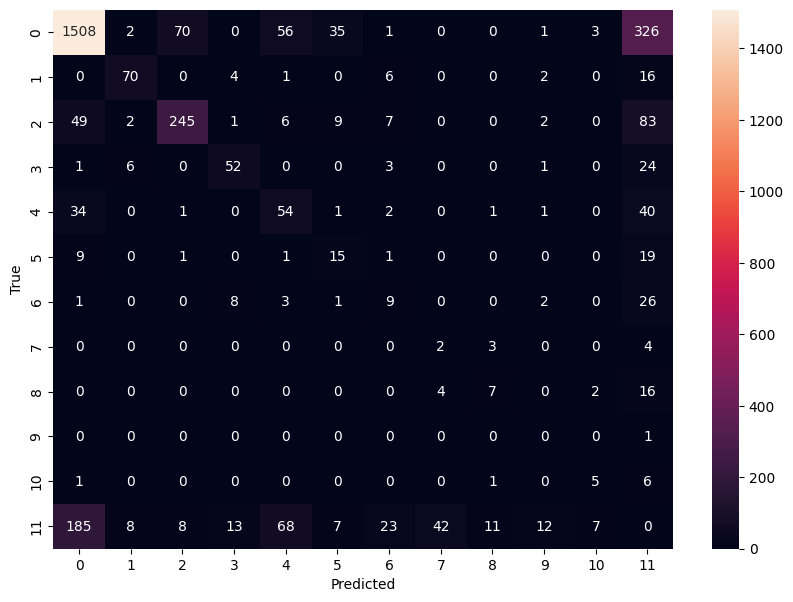

In [ ]:
# Get the confusion matrix from the results and convert it to a NumPy array
cm_array = results.confusion_matrix.matrix


# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm_array, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

---
#Run Inferences


image 1/1 /AutonomousDriving/test/00001625.jpg: 448x640 1 pickup_truck, 1 articulated_truck, 42.3ms
Speed: 3.1ms preprocess, 42.3ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


array([[[ 3,  3,  3],
        [ 2,  2,  2],
        [ 0,  0,  0],
        ...,
        [69, 77, 70],
        [ 8, 22, 18],
        [18, 33, 29]],

       [[ 2,  2,  2],
        [ 1,  1,  1],
        [ 0,  0,  0],
        ...,
        [75, 83, 76],
        [ 8, 22, 18],
        [12, 27, 23]],

       [[ 1,  1,  1],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [83, 91, 84],
        [ 8, 22, 18],
        [ 2, 17, 13]],

       ...,

       [[ 2,  2,  2],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [47, 47, 47],
        [25, 25, 25],
        [ 7,  7,  7]],

       [[ 2,  2,  2],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [47, 47, 47],
        [25, 25, 25],
        [ 7,  7,  7]],

       [[ 2,  2,  2],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [47, 47, 47],
        [25, 25, 25],
        [ 7,  7,  7]]], dtype=uint8)
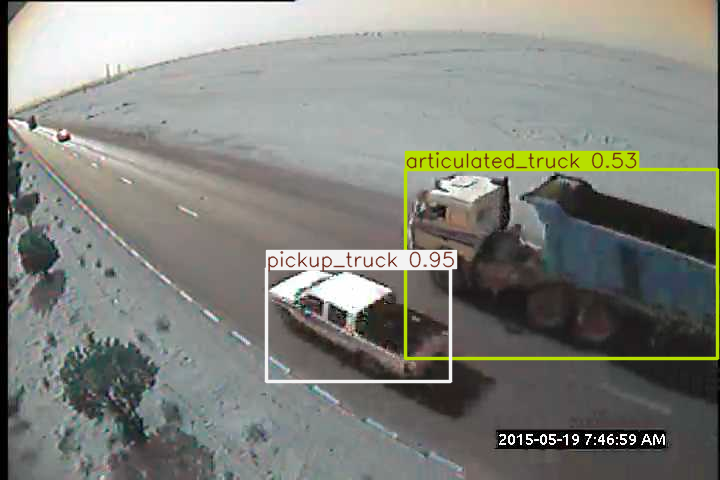

In [ ]:
model("/AutonomousDriving/test/00001625.jpg")[0].plot()

In [ ]:
results.mean_results()

[0.5144997318756361,
 0.49350459398917507,
 0.4947640138630924,
 0.34669957423143394]

---
# Cleanup


In [ ]:
shutil.rmtree(output_folder)